In [10]:

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
import re
from nltk.corpus import stopwords
from nltk import word_tokenize
STOPWORDS = set(stopwords.words('arabic'))
from bs4 import BeautifulSoup
#import plotly.graph_objs as go
#import plotly.plotly as py
#import cufflinks
#from IPython.core.interactiveshell import InteractiveShell
#import plotly.figure_factory as ff
#InteractiveShell.ast_node_interactivity = 'all'
#from plotly.offline import iplot
#cufflinks.go_offline()
#cufflinks.set_config_file(world_readable=True, theme='pearl')

In [11]:
#readind and preparing data ( text , label )
import os, sys
import pandas as pd
import numpy as np
df=pd.read_excel('ml2.xlsx', header=None) ## read le file
df.columns=['tags','post']
print(df[1:5])

   tags                                               post
1    12  محضر تحقيق بالشكوى المقدمة بنك الشرق ضد جوزف ع...
2    13      حول ادعاء طوني يارد ضد مجهول بجرم سرقة محفظته
3    11  محضر تحقيق فوري بتوقيف اللبناني فارس ورده بجرم...
4    12  محضر تحقيق بإدعاء حسام حسين قبيسي ضد المدعى عل...


In [12]:
df = df.reset_index(drop=True)
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9ا-ي #+_]')
STOPWORDS = set(stopwords.words('arabic'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = text.replace('x', '')
#    text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text
df['post'] = df['post'].apply(clean_text)

In [13]:
print(STOPWORDS)

{'اللاتي', 'متى', 'أولئك', 'لو', 'يا', 'إلى', 'بكم', 'مما', 'إذ', 'هما', 'ليست', 'كلا', 'لما', 'لعل', 'لكما', 'منذ', 'ريث', 'على', 'وإن', 'ذواتا', 'كيف', 'له', 'من', 'بل', 'تلكما', 'لدى', 'ليستا', 'إذا', 'إما', 'خلا', 'لستما', 'سوى', 'كأي', 'هذين', 'هناك', 'بنا', 'سوف', 'فيها', 'هاتين', 'هذا', 'ليت', 'منه', 'عليه', 'نحو', 'لك', 'هكذا', 'لا', 'أو', 'أينما', 'ثم', 'فمن', 'ليسوا', 'فيم', 'إليكم', 'بس', 'لهما', 'كيفما', 'بهم', 'أما', 'ثمة', 'حتى', 'به', 'لسن', 'ذلكم', 'شتان', 'كأنما', 'أنت', 'بهن', 'عن', 'أف', 'حين', 'كلاهما', 'هلا', 'والذين', 'ولو', 'إليك', 'عدا', 'لكن', 'وإذ', 'مهما', 'هذان', 'تي', 'بمن', 'لكي', 'إليكما', 'هيهات', 'اللتيا', 'حاشا', 'ذات', 'كم', 'لم', 'كلتا', 'لهم', 'ماذا', 'بين', 'ذو', 'فإن', 'هاتان', 'هذي', 'بهما', 'كما', 'عل', 'في', 'فيه', 'اللتين', 'بيد', 'ذلكما', 'عند', 'لن', 'ها', 'حيثما', 'ذين', 'بكما', 'هن', 'أيها', 'ليس', 'والذي', 'ما', 'مع', 'ألا', 'إذن', 'لوما', 'إيه', 'أولاء', 'هاهنا', 'دون', 'تلك', 'كليهما', 'لكنما', 'كليكما', 'إذما', 'اللذين', 'هيا', 'ذلكن',

In [14]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['post'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 15540 unique tokens.


In [15]:
X = tokenizer.texts_to_sequences(df['post'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (7242, 250)


In [16]:
Y = pd.get_dummies(df['tags']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (7242, 13)


In [17]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(6517, 250) (6517, 13)
(725, 250) (725, 13)


In [18]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(13, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 250, 100)          5000000   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 250, 100)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 13)                1313      
Total params: 5,081,713
Trainable params: 5,081,713
Non-trainable params: 0
_________________________________________________________________
None


In [19]:
epochs = 10
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Instructions for updating:
Use tf.cast instead.
Train on 5865 samples, validate on 652 samples
Epoch 1/10
5865/5865 [==============================] - 35s 6ms/step - loss: 2.0626 - acc: 0.3560 - val_loss: 1.1607 - val_acc: 0.6718
Epoch 2/10
5865/5865 [==============================] - 33s 6ms/step - loss: 0.8992 - acc: 0.7137 - val_loss: 0.6225 - val_acc: 0.8021
Epoch 3/10
5865/5865 [==============================] - 34s 6ms/step - loss: 0.5192 - acc: 0.8459 - val_loss: 0.4826 - val_acc: 0.8558
Epoch 4/10
5865/5865 [==============================] - 35s 6ms/step - loss: 0.3249 - acc: 0.9096 - val_loss: 0.4336 - val_acc: 0.8696
Epoch 5/10
5865/5865 [==============================] - 35s 6ms/step - loss: 0.2205 - acc: 0.9468 - val_loss: 0.4860 - val_acc: 0.8635
Epoch 6/10
5865/5865 [==============================] - 35s 6ms/step - loss: 0.1633 - acc: 0.9581 - val_loss: 0.4455 - val_acc: 0.8696
Epoch 7/10
5865/5865 [==============================] - 35s 6ms/step - loss: 0.1163 - acc: 0.97

In [20]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

725/725 [==============================] - 1s 2ms/step
Test set
  Loss: 0.479
  Accuracy: 0.883


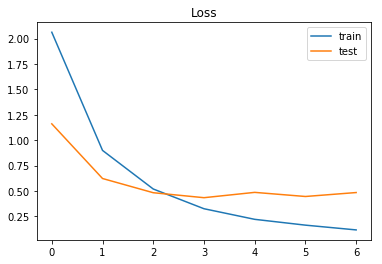

In [21]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

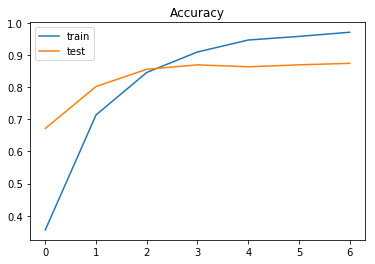

In [22]:
plt.title('Accuracy')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show();